In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_6_1_gaba_normal'

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import dill
from IPython.display import clear_output


plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
# print(mpl.rcParams.keys())


In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 16.5 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [163]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.minimum(np.maximum(q_pc,0),1)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

#     # default gaba inhibiton
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')*(1-gaba_exc)
    # calculate inhibitor input, which comes from the q_pc folded by the E-I kernel
    gaba_inh -= 0.01
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')*(1-gaba_inh)     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Input

In [164]:

# to simulate that the gaba influence on the inhibitory side is stronger
# gaba_inh = np.linspace(0.0,0.13,5)
# b = 0.05
# a = 60
# gaba_inh = 0.13 / (1 + np.exp(-(gaba_inh-b)*a) )
# gaba_exc = gaba_inh*5


gaba_inh = np.linspace(0.0,0.3,5)
gaba_inh = np.array([0.0,0.10,0.15,0.20,0.25])
gaba_inh = np.linspace(0.0,0.6,11)
gaba_exc = gaba_inh * 1.25


sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)


# store values for different parameters
q_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))
r_all = np.zeros((len(gaba_exc),len(gaba_inh),len(t),freq_bands))



############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i)/(len(t)-time_window) * gbc_input_strength


# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
# gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
# s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength


# create a linearly decreasing function in frequency band 'center_frequencyband'
# and smear it with a gauss to effect the neighboring bands
# sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
# s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


#     # Convolve with gauss curve to build a temporal ramp
#     gauss_mask = gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1)
#     s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')
#     gauss_mask = gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1)
#     s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')

# correct for border effect of convolve
s_gbc_all[-130:,gbc_center_frequencyBand] = np.max(s_gbc_all[-130:])
s_sbc_all[:130,sbc_center_frequencyBand] = np.max(s_sbc_all[:130])

############################################################
#                      Simulation                          #
############################################################

for k in range(len(gaba_exc)):
    
    l = k 

    for i in range(0, len(t)-1):

        r_all[l,k,i+1,:] = r_all[l,k,i,:] +  dt * ode_r_bpc(r_all[l,k,i,:],s_sbc_all[i],ee_kernel,g_q_out(q_all[l,k,i,:]),ei_kernel,gaba_exc[l],gaba_inh[k])       
        q_all[l,k,i+1,:] = q_all[l,k,i,:] +  dt * ode_q_pc(q_all[l,k,i,:],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

    clear_output(wait=True)
    print(k,l)




10 10


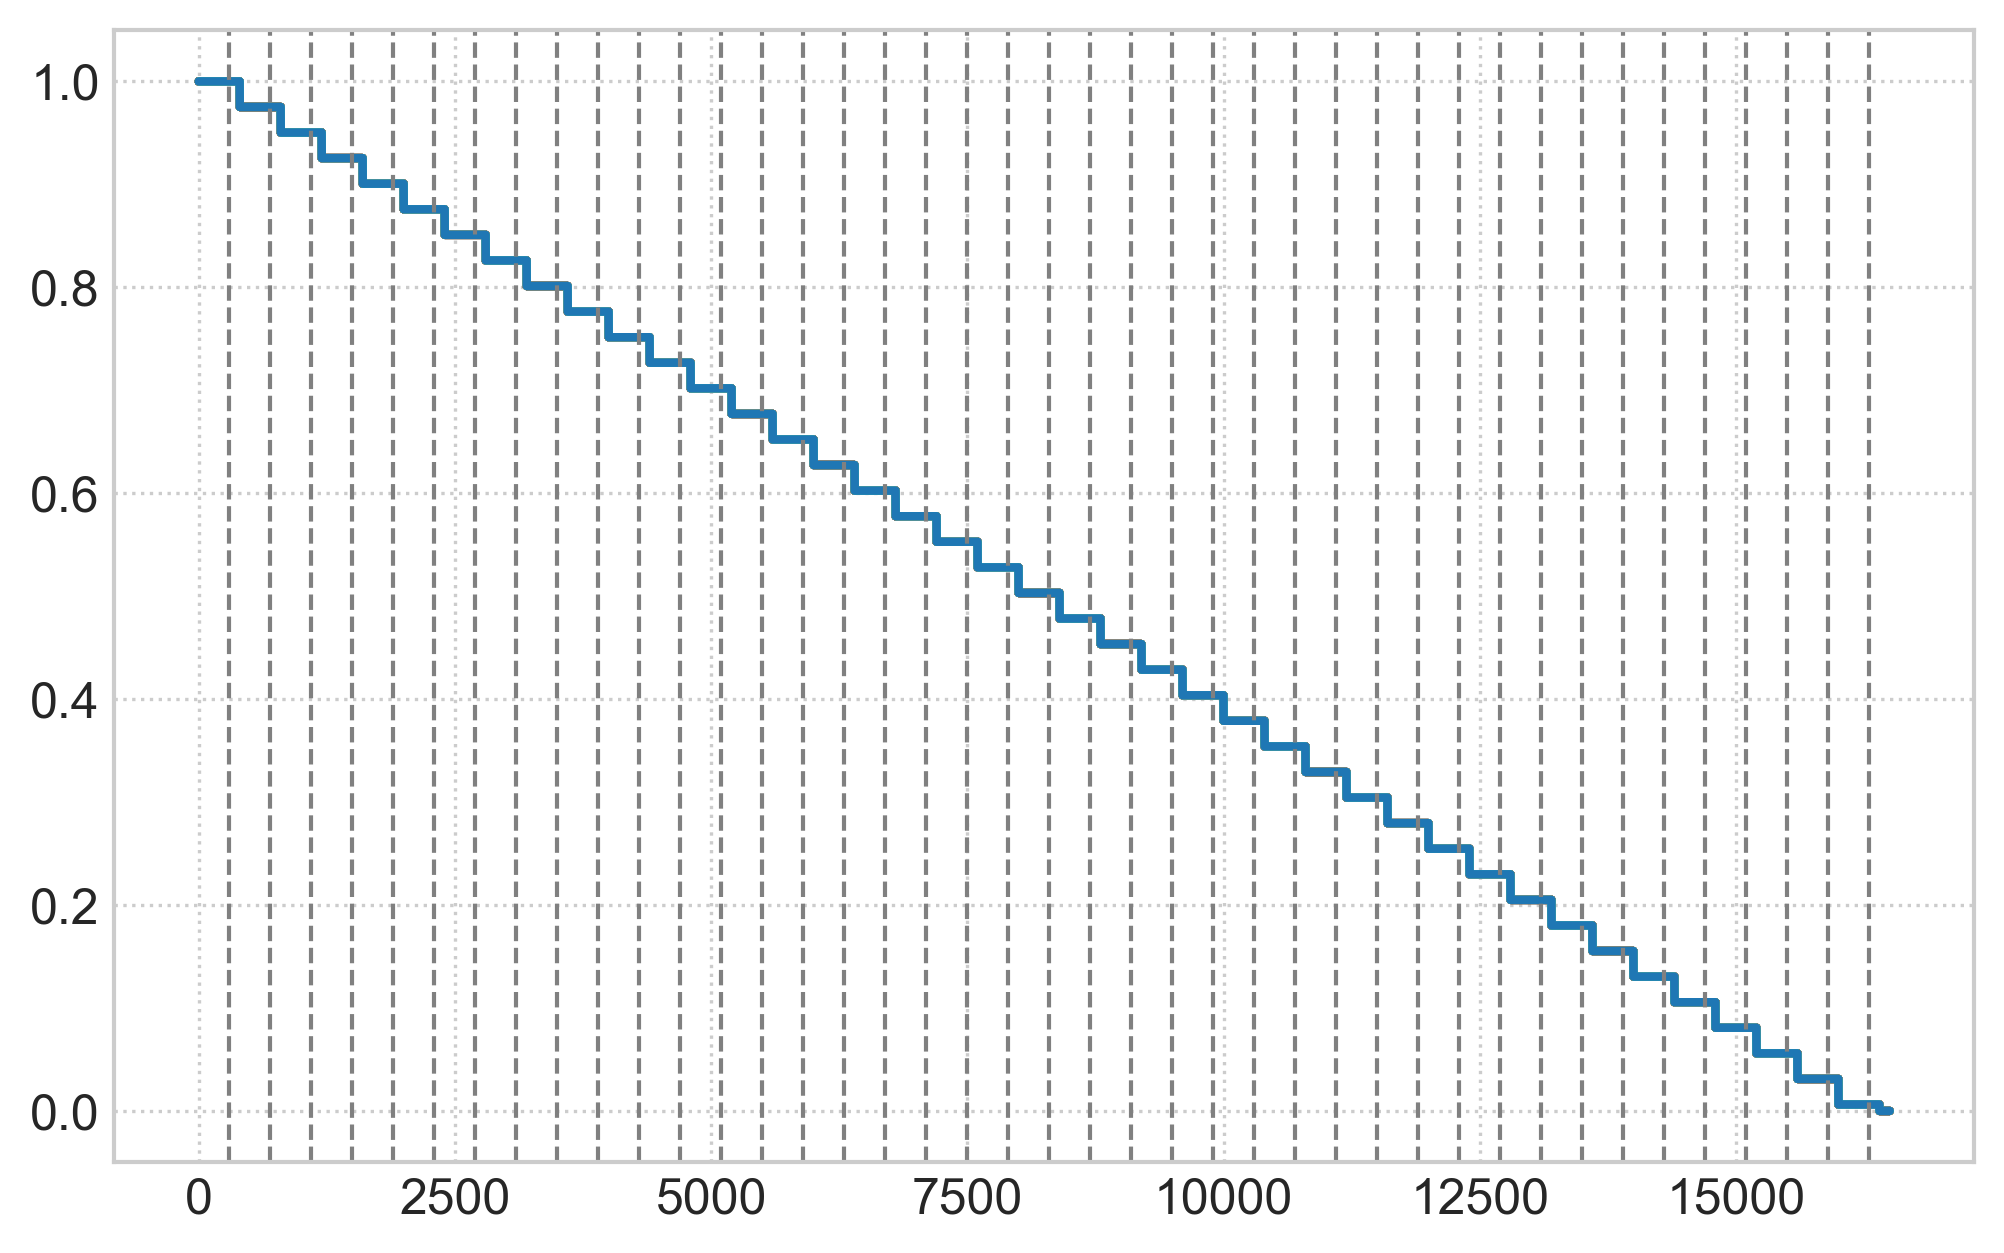

In [6]:
# Define the times when to probe
probing_times = np.arange(300,len(t),time_window)
# print(len(diff_input[probing_times]))
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for i in range(0,r.shape[0]):
    j = i
    tmp = g_r_out(r[i,j,probing_times])
    # normalize it
#     tmp = tmp / np.max(tmp)
#     ax2.plot(r_all[i,5,:,sbc_center_frequencyBand])
    ax2.plot(s_sbc_all[:,sbc_center_frequencyBand])
    
for i in probing_times:
    ax2.axvline(x=i,linewidth = 1, linestyle='--',color='grey')


# plt.savefig(figure_name + 'response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




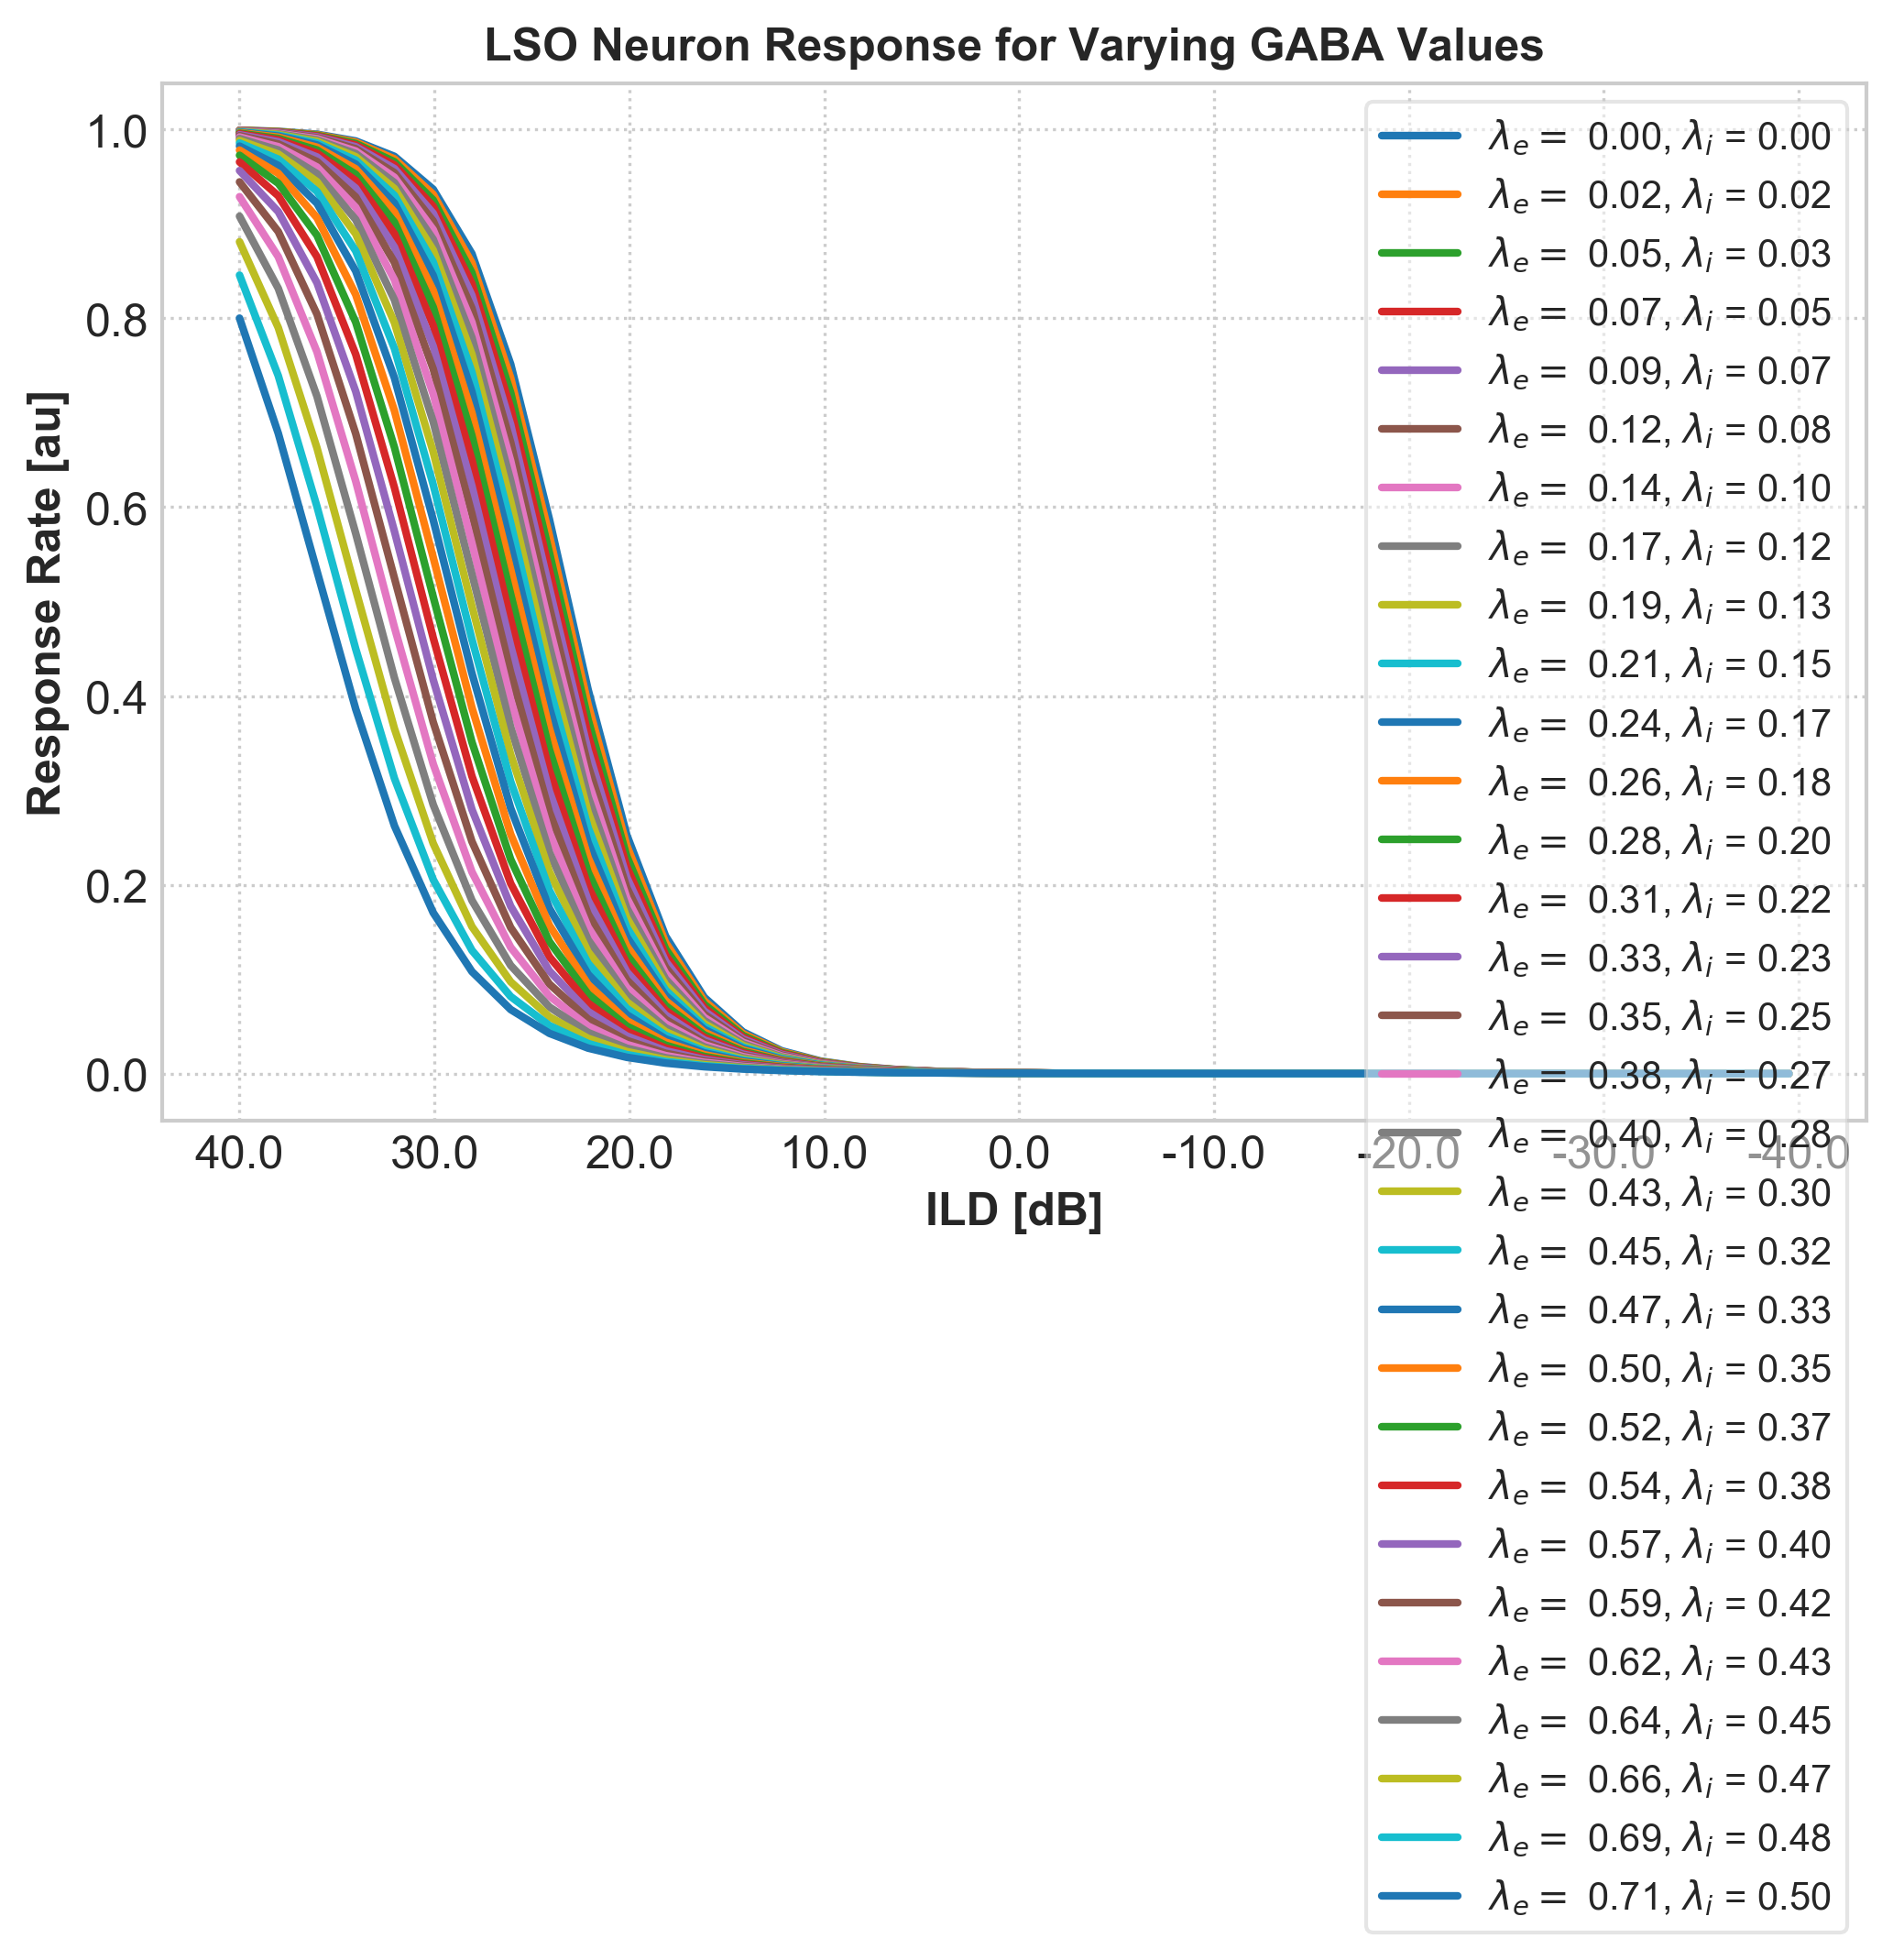

In [7]:
# Define the times when to probe
probing_times = np.arange(300,len(t),time_window)
# print(len(diff_input[probing_times]))
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for i in range(0,r.shape[0]):
    j = i
    tmp = g_r_out(r[i,j,probing_times])
    # normalize it
#     tmp = tmp / np.max(tmp)
    ax2.plot(diff_input[probing_times],tmp,linestyle='-',label=r'$\lambda_e =$ {0:.2f}, $\lambda_i$ = {1:.2f}'.format(gaba_exc[i],gaba_inh[j]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
lgd = plt.legend()

plt.savefig(figure_name + 'response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




In [ ]:
# Define the times when to probe
# probing_times = np.arange(130,len(t),time_window)

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
tmp = g_r_out(r[0,0,probing_times])
ax2.plot(diff_input[probing_times],tmp,linestyle='-',label=r'$\lambda_E =$ {0:.2f}, $\lambda_I$ = {1:.2f}'.format(gaba_exc[0],gaba_inh[0]))

tmp2 = g_r_out(r[-1,-1,probing_times])
ax2.plot(diff_input[probing_times],tmp2,linestyle='-',color='#6baed6',label=r'$\lambda_E =$ {0:.2f}, $\lambda_I$ = {1:.2f}'.format(gaba_exc[-1],gaba_inh[-1]))

ax2.fill_between(diff_input[probing_times],tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')


ax2.annotate("", xy=(0.6, 0.6), xytext=(0.86, 0.38),arrowprops=dict(arrowstyle="<-",linewidth=1))
ax2.annotate("Adaptation", xy=(0.38, 0.8), xytext=(0.75, 0.42))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
# plt.title('LSO Neuron Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
lgd = plt.legend()

plt.savefig(figure_name + 'response_shift_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig(figure_name + 'response_shift_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




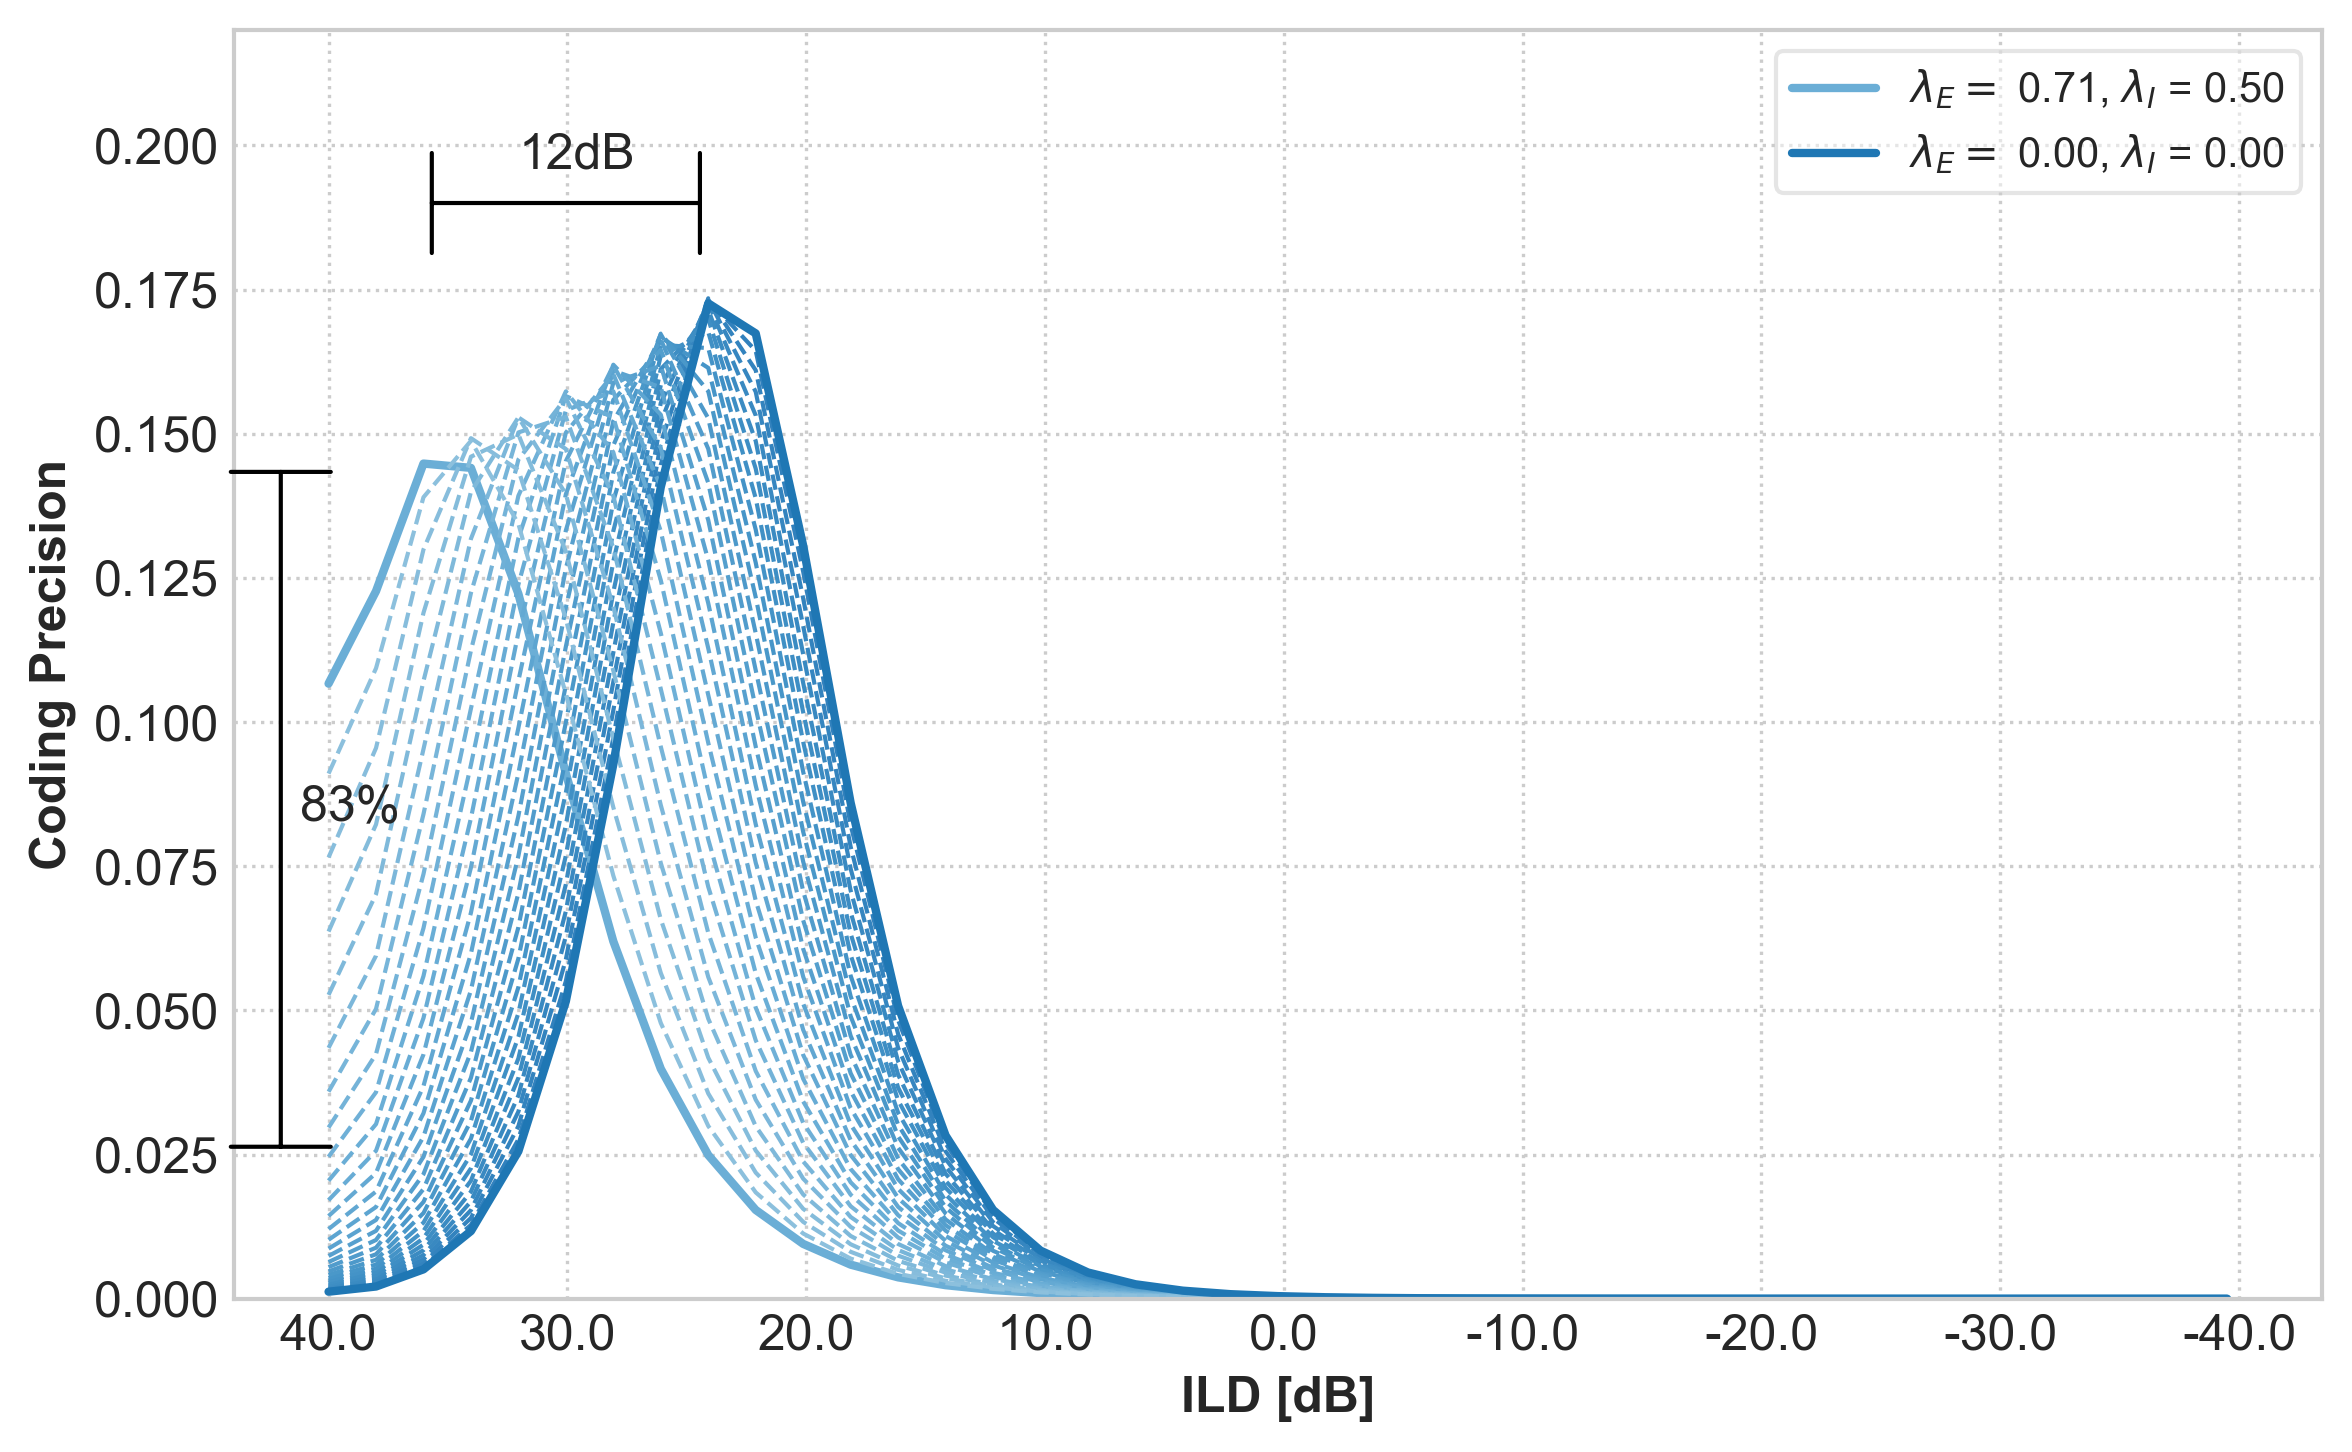

In [15]:
from mpltools import color

# fig = plt.figure()
# ax2 = fig.add_subplot(111)

probing_times = np.arange(300,len(t),time_window)
## show LSO neuron response
ilds = np.zeros((len(probing_times),len(gaba_exc)))
diff = diff_input[probing_times]
for i in range(len(gaba_exc)):
    j = i
    tmp = g_r_out(r[i,j,probing_times])
    # normalize it
#     tmp = tmp -  np.min(tmp)
#     tmp = tmp / np.max(tmp)
    ilds[:,j] = tmp

                
# ax2.plot(diff,ilds)
# # plt.plot(ilds.T)
# ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])
# ax2.invert_xaxis()

# plt.title('Normalized Response')


fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Blues(np.linspace(0.7,0.4,ilds.shape[1]))
ax2.set_prop_cycle('color', colors)

#normalize it
norm_value = np.max(ilds.flatten())
ilds /= norm_value

###########
# GRADIENT
###########

tmp2 = g_r_out(r[-2,-2,probing_times])/norm_value
# tmp2 = tmp2 -  np.min(tmp2)
# tmp2 = tmp2 / np.max(tmp2)
ax2.plot(diff,-np.gradient(tmp2),linestyle='-',color='#6baed6',label=r'$\lambda_E =$ {0:.2f}, $\lambda_I$ = {1:.2f}'.format(gaba_exc[-1],gaba_inh[-1]))


tmp =-np.array( np.gradient(ilds,axis=0))
ax2.plot(diff,tmp[:,:-2],linewidth = int(drawing_size/9),linestyle='--')

tmp = g_r_out(r[0,0,probing_times])/norm_value
# tmp = tmp -  np.min(tmp)
# tmp = tmp / np.max(tmp)

ax2.plot(diff,-np.gradient(tmp),linestyle='-',color='C0',label=r'$\lambda_E =$ {0:.2f}, $\lambda_I$ = {1:.2f}'.format(gaba_exc[0],gaba_inh[0]))




# calculate x value for first peak
x1 = diff[np.argmax(-np.gradient(tmp))]
x2 = diff[np.argmax(-np.gradient(tmp2))]
ax2.annotate("", xy=(x2, 0.19), xytext=(x1, 0.19),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}dB".format((x2-x1)*40), xy=((x2-x1)/2 -x2, 0.196), xytext=((x2-x1)/2 +x1+0.05, 0.196))

y1 = np.max(-np.gradient(tmp2))
y1_ind = np.argmax(-np.gradient(tmp))
y2 = -np.gradient(tmp2)[y1_ind]

ax2.annotate("", xy=(1.05, y1), xytext=(1.05, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(1.03, y2+(y1-y2)/2), xytext=(1.03,  y2+(y1-y2)/2 -0.002))


# # calculate x value for first peak
# x1 = diff[np.argmax(-np.gradient(tmp))]
# x2 = diff[np.argmax(-np.gradient(tmp2))]
# ax2.annotate("", xy=(x2, 0.19), xytext=(x1, 0.19),arrowprops=dict(arrowstyle="|-|",linewidth=1))
# ax2.annotate("{0:2.0f}dB".format((x2-x1)*40), xy=((x2-x1)/2 -x2, 0.196), xytext=((x2-x1)/2 +x1+0.05, 0.196))


# y1 = np.max(-np.gradient(tmp))
# y2 = np.max(-np.gradient(tmp2))
# ax2.annotate("", xy=(0.18, y1), xytext=(0.18, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
# ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(0.14, y2+(y1-y2)/2), xytext=(0.14,  y2+(y1-y2)/2 -0.002))


l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
ax2.set_ylabel('Coding Precision')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.22])
# ax2.set_xlim([1,-1])
ax2.legend()
# plt.title('Coding Precision')

plt.tight_layout()

plt.savefig(figure_name + 'coding_prescision.svg', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'coding_prescision.tiff', bbox_inches='tight')

plt.show()



In [12]:
import dill
dill.dump_session('fig_6_1_gaba_influence_normal')
# dill.load_session('fig_6_1_gaba_influence_normal')